In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.figure_4 import plot_figure_4

from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives, calc_decay_windows, _halflife
from jtb_2022_code import FigureSingleCellData
from inferelator_velocity import decay

import inferelator_velocity as ifv

import numpy as np
import pandas as pd

In [3]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()
data.load_pseudotime(do_rho=False)

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [4]:
data.expt_data[(1, "WT")]

AnnData object with n_obs × n_vars = 63533 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'Pool_Combined', 'program_0_time', 'program_1_time', 'program_rapa_time', 'program_cc_time', 'dpt_pt', 'cellrank_pt', 'monocle_pt', 'palantir_pt'
    var: 'n_cells', 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'Cell Cycle', 'Other', 'category', 'program'
    uns: 'log1p', 'neighbors', 'noise2self', 'pca', 'program_0_pca', 'program_1_pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'program_0_pca', 'program_1_pca', 'dpt_False', 'cellrank_False', 'monocle_False', 'palantir_False', 'dpt_True', 'cellrank_True', 'monocle_True', 'palantir_True'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'noise2self_distance_graph'

In [5]:
import gc
import numpy as np

if 'rapamycin_window_decay' not in data.expt_data[(2, "fpr1")].varm:
    for k in data.expts:
        _decay = data.decay_data(*k)

        for vark in ['rapamycin_window_decay', 'cell_cycle_window_decay']:
            data.expt_data[k].varm[vark] = _decay.varm[vark]
            data.expt_data[k].varm[vark + "_se"] = _decay.varm[vark + "_se"]
            data.expt_data[k].uns[vark] = _decay.uns[vark]
            
        for vark in ['rapamycin_decay', 'rapamycin_decay_se', 'cell_cycle_decay', 'cell_cycle_decay_se']:
            data.expt_data[k].var[vark] = _decay.var[vark].copy()
            
        _idx = [_decay.var_names.get_loc(x) for x in FIGURE_4_GENES]
        
        data.expt_data[k].obsm['FIG4_EXPR'] = _decay.X[:, _idx]
        data.expt_data[k].obsm[f'FIG4_{RAPA_VELO_LAYER}'] = _decay.layers[RAPA_VELO_LAYER][:, _idx]
        data.expt_data[k].obsm[f'FIG4_{CC_VELO_LAYER}'] = _decay.layers[CC_VELO_LAYER][:, _idx]

        del _decay
        gc.collect()
        
    data.decay_data_all()

Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_fpr1.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_fpr1.h5ad


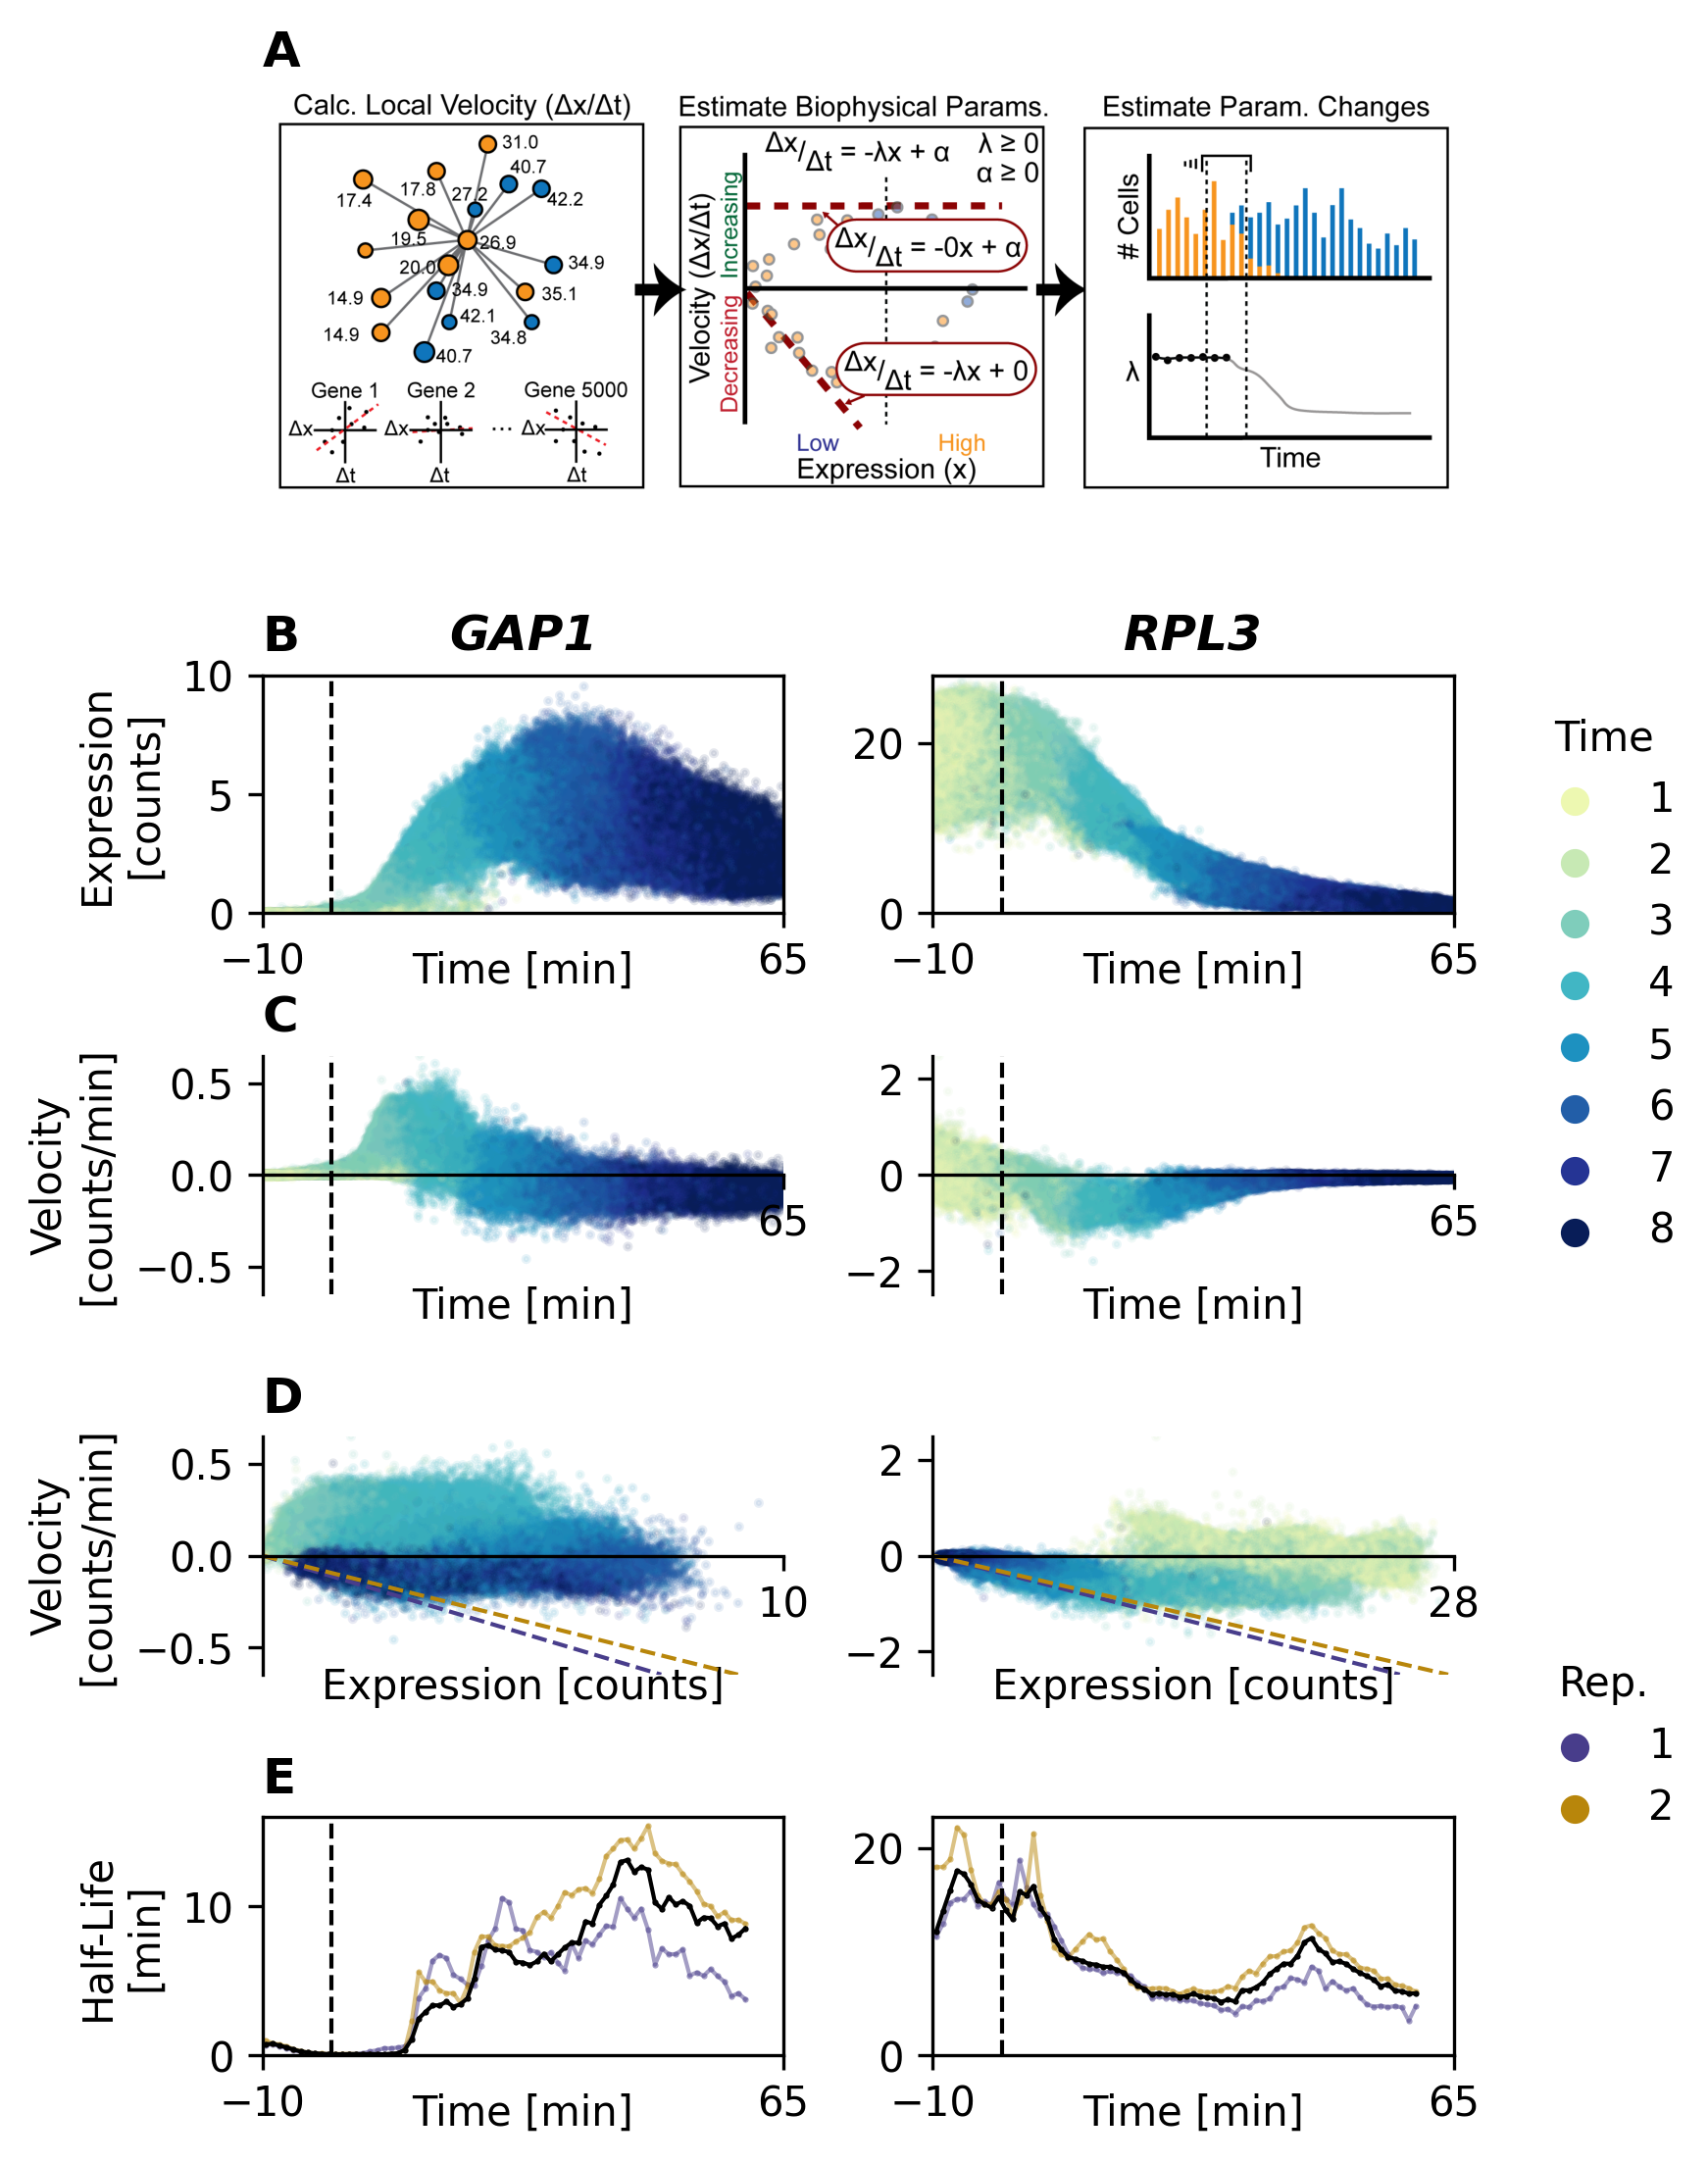

In [6]:
fig = plot_figure_4(data)

In [7]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.decay_common import _halflife

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import gc

TIME_LIMITS = [-10, 65]
VLINE_X = 0
  
def plot_figure_4(data, save=True):
    rgen = np.random.default_rng(100)

    rep_colors = ['darkslateblue', 'darkgoldenrod', 'black']

    panel_labels = {'schematic': "A",
                    'expr_1': "B",
                    'velocity_1': "C",
                    'decay_1': "D",
                    'decaytime_1': "E"}

    layout = [['schematic', 'schematic', 'schematic', '.'],
              ['expr_1', '.', 'expr_2', 'time_lgd'],
              ['velocity_1', '.', 'velocity_2', 'time_lgd'],
              ['decay_1', '.', 'decay_2', 'rep_lgd'],
              ['decaytime_1', '.', 'decaytime_2', 'rep_lgd']]

    fig_refs = {}

    fig, axd = plt.subplot_mosaic(layout,
                                  gridspec_kw=dict(width_ratios=[1, 0.01, 1, 0.2], 
                                                   height_ratios=[2, 1, 1, 1, 1],
                                                   wspace=0.25, hspace=0.5), 
                                  figsize=(6, 11), dpi=300)

    fig_refs['schematic'] = axd['schematic'].imshow(plt.imread(FIG3A_FILE_NAME), aspect='equal')

    def _minmax(arr):
        return np.nanmin(arr), np.nanmax(arr)

    def _minmax_list(lst):
        return min(l[0] for l in lst), max(l[1] for l in lst)

    def _get_limits(layer, symmetric=False):
        limits = {g: _minmax_list(
            [_minmax(data.expt_data[(j, k)].obsm[layer][:, [x == g for x in FIGURE_4_GENES]]) for j in range(1, 3) for k in ["WT"]]
        )
        for g in FIGURE_4_GENES}

        if not symmetric:
            return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
        else:
            return {g: (-1 * np.max(np.abs(v)), np.max(np.abs(v))) for g, v in limits.items()}

    def _get_halflife_limits(decay_key='rapamycin_window_decay', se_key='rapamycin_window_decay_se', max_halflife=120):
        limits = {g: _minmax_list([_minmax(_halflife(data.expt_data[(j, k)].varm[decay_key][data.expt_data[(j, k)].var_names == g, :].flatten() -
                                                     data.expt_data[(j, k)].varm[se_key][data.expt_data[(j, k)].var_names == g, :].flatten()))
                                 for j in range(1, 3) 
                                 for k in ["WT"]]) for g in FIGURE_4_GENES}
        return {g: (0, np.ceil(min(max_halflife, v[1]))) for g, v in limits.items()}
           
    expr_limits = _get_limits('FIG4_EXPR')
    velocity_limits = _get_limits(f'FIG4_{RAPA_VELO_LAYER}', symmetric=True)
    halflife_limits = _get_halflife_limits()

    for a in ['time_lgd', 'rep_lgd', 'schematic']:
        axd[a].axis('off')

    def _replot_axes(ax):
        ax.spines['left'].set_position(('axes', 0.0))
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position(('data', 0.0))
        ax.spines['top'].set_color('none')

    def _gene_data(gene, t_key='time_pca_pt', layer='FIG4_EXPR'):    
        g_data = np.concatenate([data.expt_data[(i, "WT")].obsm[layer][:, [gene == x for x in FIGURE_4_GENES]].flatten()
                                 for i in range(1, 3)])
        t_data = np.concatenate([data.expt_data[(i, "WT")].obs[RAPA_TIME_COL].values
                                 for i in range(1, 3)])
        pools = np.concatenate([data.expt_data[(i, "WT")].obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values
                                for i in range(1, 3)])

        return g_data, t_data, pools

    def _decay_data(gene):
        decays = [data.expt_data[(i, "WT")].varm['rapamycin_window_decay'][data.expt_data[(i, "WT")].var_names == gene, :].flatten()
                  for i in range(1, 3)]
        times = data.expt_data[(1, "WT")].uns['rapamycin_window_decay']['times']
        
        decays.append(data.all_data.varm['rapamycin_window_decay'][data.all_data.var_names == gene, :].flatten())

        dcs = [data.expt_data[(i, "WT")].var.loc[data.expt_data[(i, "WT")].var_names == gene, 'rapamycin_decay'][0]
               for i in range(1, 3)]

        return decays, times, dcs

    for i, g in enumerate(FIGURE_4_GENES):
        expr_data, time_data, color_data = _gene_data(g)
        velocity_data, _, _ = _gene_data(g, layer=f'FIG4_{RAPA_VELO_LAYER}')

        overplot_shuffle = np.arange(expr_data.shape[0])
        rgen.shuffle(overplot_shuffle)

        expr_data = expr_data[overplot_shuffle]
        time_data = time_data[overplot_shuffle]
        color_data = color_data[overplot_shuffle]
        velocity_data = velocity_data[overplot_shuffle]

        ### PANEL A ###
        a_ref = "expr_" + str(i + 1)
        fig_refs[a_ref] = axd[a_ref].scatter(x=time_data, 
                                             y=expr_data,
                                             c=color_data,
                                             alpha=0.1, 
                                             s=2)
        axd[a_ref].set_xlim(*TIME_LIMITS)
        axd[a_ref].set_xticks(TIME_LIMITS)
        axd[a_ref].set_ylim(*expr_limits[g])
        axd[a_ref].set_ylabel("Expression\n[counts]") if i == 0 else None
        axd[a_ref].set_xlabel("Time [min]", labelpad=-8)
        axd[a_ref].set_title(data.gene_common_name(g), 
                             fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})
        axd[a_ref].axvline(VLINE_X, 0, 1, linestyle='--', linewidth=1.0, c='black')

        ### PANEL B ###
        b_ref = "velocity_" + str(i + 1)
        fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.1, 
                                             s=2) 
        
        axd[b_ref].set_xlim(*TIME_LIMITS)
        axd[b_ref].set_xticks([TIME_LIMITS[1]])
        axd[b_ref].set_ylim(*velocity_limits[g])
        axd[b_ref].set_ylabel("Velocity\n[counts/min]") if i == 0 else None
        axd[b_ref].set_xlabel("Time [min]", labelpad=10)
        axd[b_ref].axvline(VLINE_X, 0, 1, linestyle='--', linewidth=1.0, c='black')
        
        _replot_axes(axd[b_ref])

        ### PANEL C ###
        c_ref = "decay_" + str(i + 1)
        decays, times, decay_consts = _decay_data(g)


        fig_refs[c_ref] = axd[c_ref].scatter(x=expr_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.1, 
                                             s=2)

        axd[c_ref].set_xlim(*expr_limits[g])
        axd[c_ref].set_xticks([expr_limits[g][1]])
        axd[c_ref].set_ylim(*velocity_limits[g])
        axd[c_ref].set_ylabel("Velocity\n[counts/min]") if i == 0 else None
        axd[c_ref].set_xlabel("Expression [counts]", labelpad=10)


        for rc, dc in zip(rep_colors, decay_consts):
            axd[c_ref].axline((0, 0), slope = -1 * dc, c=rc, linestyle='--', linewidth=1.0)

        _replot_axes(axd[c_ref])

        ### PANEL D ###
        d_ref = "decaytime_" + str(i + 1)

        for ic, i_decays in zip(rep_colors, decays):
            axd[d_ref].plot(
                times, 
                _halflife(i_decays), 
                marker=".", 
                linestyle='-', 
                linewidth=1.0, 
                markersize=1, 
                c=ic,
                alpha=1 if ic == 'black' else 0.5
            )

        axd[d_ref].set_xlim(*TIME_LIMITS)
        axd[d_ref].set_xticks(TIME_LIMITS)
        axd[d_ref].set_ylim(*halflife_limits[g])

        axd[d_ref].axvline(VLINE_X, 0, 1, linestyle='--', linewidth=1.0, c='black')
        axd[d_ref].set_ylabel("Half-Life\n[min]") if i == 0 else None
        axd[d_ref].set_xlabel("Time [min]", labelpad=-8)


    fig_refs['time_lgd'] = add_legend(axd['time_lgd'], 
                                      pool_palette(), 
                                      data.all_data.obs['Pool'].dtype.categories.values,
                                      title="Time")

    fig_refs['time_lgd'] = add_legend(axd['rep_lgd'], 
                                      rep_colors, 
                                      data.all_data.obs['Experiment'].dtype.categories.values,
                                      title="Rep.")

    for ax_id, label in panel_labels.items():
        axd[ax_id].set_title(label, loc='left', weight='bold')

    if save:
        fig.savefig(FIGURE_4_FILE_NAME + ".png", facecolor='white', bbox_inches='tight')
    
    return fig